In [1]:
%reload_ext autoreload
%autoreload 2

import torch
from torch import nn

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# azure setting
torch.multiprocessing.set_sharing_strategy('file_system')


c:\Users\androgo\anaconda3\envs\pytorch_env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


###  Testing CNN-BIGRU model obtained from optimization with  evaluation function for f1_score

In [2]:
# the resulting params from optuna optimization:
model_parameters = """Best trial:
                number of the best trial:  7
                  Value: 0.11880768090486526
                  Params: 
                    n_layers: 3
                    
                    n_units_l0: 70
                    no_strides_l0: 3
                    n_units_l1: 85
                    no_strides_l1: 1
                    n_units_l2: 64
                    no_strides_l2: 7
                    
                    dropout_l2: 0.2360531735539034
                    learning_rate: 0.010737792310750963
                    optimizer: RMSprop
                  Evaluation function: f1_score"""

In [3]:
#the model is made from the best parameters found by optuna 

class CNN_BIGRU(nn.Module):
    def __init__(self,args):
        super(CNN_BIGRU, self).__init__()
        
        kernel_size=3
        self.number_of_classes = args["number_of_classes"]
        self.input_shape = args["input_shape"]
        self.input_size=args["input_shape"][1]
        self.batch_size = args["input_shape"][0]
        
                
        self.cv1 = nn.Conv1d(self.input_size, 70, kernel_size=3, stride=3,bias=False)
        self.avgp1 = nn.AvgPool1d(kernel_size=3, stride=3)
        self.gn1 = nn.GroupNorm(10, 70)
        self.lrelu1 = nn.LeakyReLU(inplace=True)

        self.cv2 = nn.Conv1d(70, 85, kernel_size=1, stride=1,bias=False)
        self.avgp2 = nn.AvgPool1d(kernel_size=1, stride=1)
        self.gn2 = nn.GroupNorm(17, 85)
        self.lrelu2 = nn.LeakyReLU(inplace=True)

        self.cv3 = nn.Conv1d(85, 64, kernel_size=1, stride=7,bias=False)
        self.avgp3 = nn.AvgPool1d(kernel_size=1, stride=7)
        self.gn3 = nn.GroupNorm(16, 64)
        self.lrelu3 = nn.LeakyReLU(inplace=True)



        #Expected hidden size (4, 32, 128), got [4, 32, 64]
        self.bigru =nn.GRU(
                    input_size=64,
                    hidden_size=64 * 2,
                    #hidden_size=64,
                    num_layers=2,
                    batch_first=True,
                    dropout=0.236,
                    bidirectional=True,
                    )

        self.fc_output = nn.Linear(64*4, self.batch_size)
        #self.fc_output = nn.Linear(64*2, self.batch_size)
        
        self.initialize_weights()
        
    def forward(self, x):
        out = self.cv1(x)
        assert not torch.isnan(out).any()
        out = self.avgp1(out)
        out = self.gn1(out)
        out = self.lrelu1(out)
        
        out = self.cv2(out)
        assert not torch.isnan(out).any()
        out = self.avgp2(out)
        out = self.gn2(out)
        out = self.lrelu2(out)
        
        
        out = self.cv3(out)
        assert not torch.isnan(out).any()
        out = self.avgp3(out)
        out = self.gn3(out)
        out = self.lrelu3(out)        
        
        outputs = torch.transpose(out, 1, 2)
        
        h0 = torch.zeros( 2 * 2, outputs.size(0), 64*2).to(DEVICE)
        outputs, hidden = self.bigru(outputs, h0)
        assert not torch.isnan(outputs).any()

        outputs = self.fc_output(outputs)
        assert not torch.isnan(outputs).any()

        outputs = outputs.view(batch_size, -1)
        linear_output = (nn.Linear(outputs.shape[1], number_of_classes)).to(DEVICE)
            
        # apply Linear to get shape of: (batch_size,number_of_classes)
        # the Linear is generated in this way to make the output fit the required shape and to let RNN layer be as wide as possible
        outputs = linear_output(outputs)            
        assert not torch.isnan(outputs).any()
                    
        # reshaped because CrossEntropyLoss has to match the target
        outputs = outputs.unsqueeze(2)
        
        return outputs
    
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_uniform_(m.weight.data, nonlinearity="leaky_relu")
                if m.bias is not None:
                    nn.init.constant_(m.bias.data, 0)
            elif isinstance(m, nn.Linear):
                torch.nn.init.kaiming_uniform_(m.weight.data, nonlinearity="leaky_relu")
                if m.bias is not None:
                    nn.init.constant_(m.bias.data, 0)
            elif isinstance(m, nn.GroupNorm):
                nn.init.constant_(m.weight.data, 1)
                nn.init.constant_(m.bias.data, 0)
                

In [4]:
import torch
from models_hyper_optim_optuna_interface import get_path_from_folder, define_model, create_study_optimization, utils_data_load

max_epochs_trainning = 18


batch_size = 32
number_of_classes = 15
channels = 1
input_size = 23
evaluation_function ='f1_score'

args_model = {
    'number_of_classes':number_of_classes, 
    'input_shape' : (batch_size, channels, input_size)
    }


dataInputParams, models_trainning = define_model(batch_size, max_epochs_trainning, evaluation_function = evaluation_function, USE_AUTOMATIC_MIXED_PRECISION=False)

DEVICE found:  cuda:0
number of classes:  15


c:\Users\androgo\anaconda3\envs\pytorch_env\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


c:\Users\androgo\Documents\Python Scripts\IDS\CICIDS2017_notebooks\IDS_Project
X_train__23_features (1789827, 23)
X_test__23_features (606432, 23)
y_train_binary__23_features (1789827,)
0.0     1497160
4.0      128632
2.0       96004
10.0      42979
3.0        7709
7.0        4110
6.0        3967
5.0        3882
11.0       2303
1.0        1457
12.0       1084
14.0        489
9.0          27
13.0         16
8.0           8
dtype: int64
Y_test__binary (606432,)


c:\Users\androgo\anaconda3\envs\pytorch_env\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


classes_y:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
class_weights:  [7.96987630e-02 8.18955388e+01 1.24288363e+00 1.54782462e+01
 9.27621432e-01 3.07371973e+01 3.00785984e+01 2.90320681e+01
 1.49152250e+04 4.41932593e+03 2.77628144e+00 5.18114633e+01
 1.10075461e+02 7.45761250e+03 2.44011861e+02]

classes_class_weights: 
{0: 0.08,
 1: 81.896,
 2: 1.243,
 3: 15.478,
 4: 0.928,
 5: 30.737,
 6: 30.079,
 7: 29.032,
 8: 14915.225,
 9: 4419.326,
 10: 2.776,
 11: 51.811,
 12: 110.075,
 13: 7457.612,
 14: 244.012}


c:\Users\androgo\anaconda3\envs\pytorch_env\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [5]:
cnn_bigru_model = CNN_BIGRU(args_model)
optimizer = torch.optim.RMSprop(cnn_bigru_model.parameters(), lr=0.01073, alpha=0.99, eps=1e-08, centered=False)   

def load_model_from_checkpoint(model, optimizer, max_epochs_trainning, evaluation_function):
    checkpoint = torch.load("best_optimized_models/cnn/"+ evaluation_function +"/"+"cnnbigru_trainned_"+ str(max_epochs_trainning))
    model.load_state_dict(checkpoint['model'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    
    return model, optimizer

load_model_from_checkpoint(cnn_bigru_model, optimizer, max_epochs_trainning=max_epochs_trainning, evaluation_function='f1_score')

models_trainning.setParameters(
    cnn_bigru_model,
    optimizer
)

accuracies_scores, losses_scores, f1_scores, auroc_scores = models_trainning.testNetModel()

100%|██████████| 18951/18951 [09:07<00:00, 34.63it/s]


In [6]:
import utils.utils as utils

multi_class_accuracies = models_trainning.get_multi_class_accuracies()
accuracy_trainning, f1_score_trainning, auroc_trainning = models_trainning.get_evaluations_score()

print(
    "\nTest set: Average loss: {:.4f}, Average accuracy: {:.4f}%, \n \t  Average f1_score: {:.4f}%, Average Area Under ROC: {:.4f} \n".format(
        utils.computeMean(losses_scores),
        accuracy_trainning,
        f1_score_trainning,
        auroc_trainning,
    )
)
print("Test set multi class accuracies: ", multi_class_accuracies)        


i=-1
for  key in utils_data_load.labels_dict.keys():
    i=i+1
    print("Accuracy for class ", key, " is ", multi_class_accuracies[i])


Test set: Average loss: 2.7289, Average accuracy: 6.6748%, 
 	  Average f1_score: 11.2319%, Average Area Under ROC: 0.5004 

Test set multi class accuracies:  [6.65, 6.38, 7.28, 6.34, 6.41, 7.26, 6.2, 5.91, 33.33, 11.11, 6.95, 9.51, 8.31, 0.0, 5.52]
Accuracy for class  BENIGN  is  6.65
Accuracy for class  Bot  is  6.38
Accuracy for class  DDoS  is  7.28
Accuracy for class  DoS GoldenEye  is  6.34
Accuracy for class  DoS Hulk  is  6.41
Accuracy for class  DoS Slowhttptest  is  7.26
Accuracy for class  DoS slowloris  is  6.2
Accuracy for class  FTP-Patator  is  5.91
Accuracy for class  Heartbleed  is  33.33
Accuracy for class  Infiltration  is  11.11
Accuracy for class  PortScan  is  6.95
Accuracy for class  SSH-Patator  is  9.51
Accuracy for class  Web Attack � Brute Force  is  8.31
Accuracy for class  Web Attack � Sql Injection  is  0.0
Accuracy for class  Web Attack � XSS  is  5.52


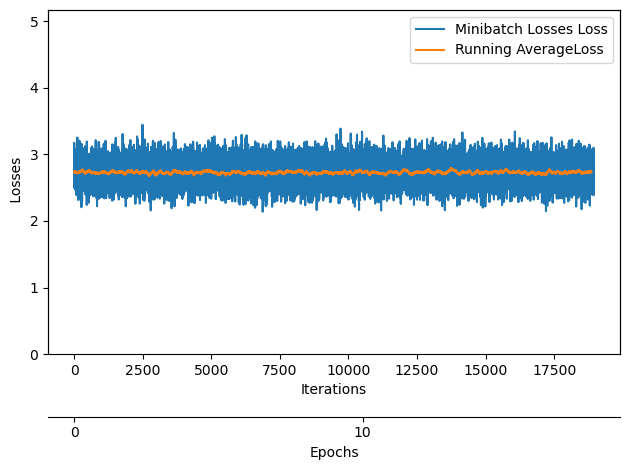

In [7]:
from utils.utils_plotting import plot_trainning_eval

plot_trainning_eval(
        losses_scores, num_epochs=max_epochs_trainning, type_plot="Losses", custom_label="Loss"
    )